In [188]:
!pip install cvxopt
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
from cvxopt import matrix, solvers

You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [189]:
rows = 10
cols = 10

# Q1) Creating reward functions and the heatmap

In [230]:
reward_function_1 = [[0.0 for x in range(cols)] for y in range(rows)]
reward_function_1[rows - 1][cols - 1] = 1.0
reward_function_1 = np.array(reward_function_1)

In [231]:
reward_function_2 = [[0.0 for x in range(cols)] for y in range(rows)]
reward_function_2 = np.array(reward_function_2)
reward_function_2[1:7,4] = -100.0
reward_function_2[1,5] = -100.0
reward_function_2[1:4,6] = -100.0
reward_function_2[7:9,6] = -100.0
reward_function_2[3,7] = -100.0
reward_function_2[7,7] = -100.0
reward_function_2[3:8,8] = -100.0
reward_function_2[9,9] = 10.0

In [243]:
np.random.seed(1234)

In [361]:

## Heatmap Function 
def heatmap(r, name):    
    plt.figure(figsize = (20,20))

    plt.imshow(r, vmin=-1, vmax=1)
    ax = plt.gca()
    plt.colorbar()
    #plt.title('Reward Function 1 heatmap', y=1.1)
    for y in range(10):
        for x in range(10):
            plt.text(x, y , '%.4f' % int(r[y, x]),
                     horizontalalignment='center',
                     verticalalignment='center', fontsize=15, color = 'w'
                     )
    ax.xaxis.tick_top()
    ax.set_xticks(np.arange(-0.5, 9, 1))
    ax.set_yticks(np.arange(-0.5, 9, 1))
    ax.set_xticklabels(np.arange(0, 10, 1))
    ax.set_yticklabels(np.arange(0, 10, 1))
    ax.grid(color='w', linestyle='-', linewidth=1)

    plt.text(0.5, 1.08, 'Heatmap for Reward Function - %s' %name,
             horizontalalignment='center',
             fontsize=40,
             transform = ax.transAxes)
    ax.xaxis.set_label_position('top')

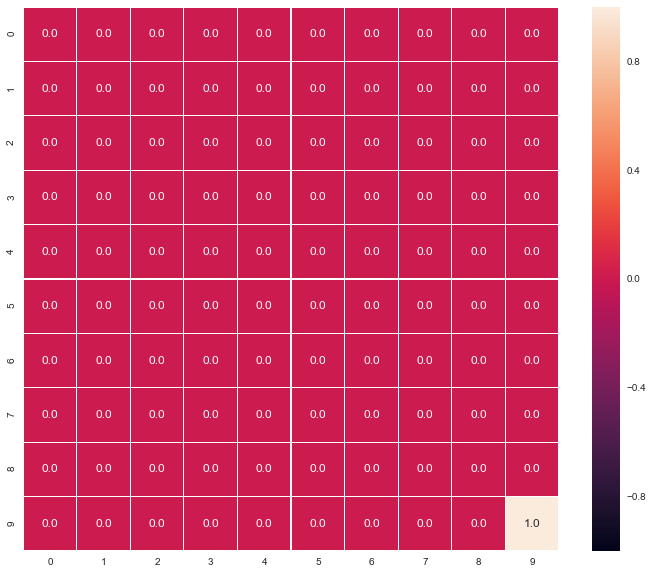

In [385]:
# heatmap(reward_function_1, '1')

import seaborn as sns; sns.set()
plt.figure(figsize = (12, 10))
sns.heatmap(reward_function_1, annot=reward_function_1, linewidths=0.1, fmt='', vmin=-1, vmax=1)


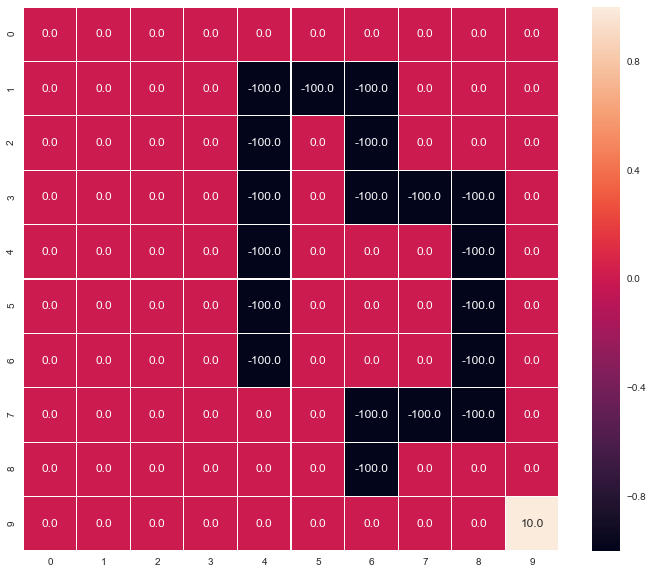

In [384]:
# heatmap(reward_function_2, '2')

plt.figure(figsize = (12, 10))
sns.heatmap(reward_function_2, annot=reward_function_2, linewidths=0.1, fmt='', vmin=-1, vmax=1)

# 2 Creating the environment for the agent

In [308]:
#Utility functions for the environment setup

def get_neighbors(state, rows, cols):
    left = state - rows
    
    right = state + rows
    
    #for states in last col
    if(right > rows*cols - 1):
        right = -1
    
    #for states in first row
    if(state % rows == 0):
        up = -1
    else:
        up = state - 1
    
    #for states in last row
    if(state % rows == rows -1):
        down = -1
    else:
        down = state + 1
    
    return {'L':left,'R':right,'U':up,'D': down}

def assign_prob(current_state, neighbors, action, wind_prob):

    current_state_prob = 0.0
    result_prob = {}
    for action_neigh in neighbors.keys():
        goto_state = neighbors[action_neigh]
        if(action_neigh == action):
            
            if(goto_state < 0):
                current_state_prob = current_state_prob + 1 - wind_prob + (wind_prob/4)
                result_prob[action_neigh] = 0.0
            else:
                result_prob[action_neigh] = 1 - wind_prob + (wind_prob/4)
        
        else:
            
            if(goto_state < 0):
                current_state_prob = current_state_prob + (wind_prob/4)
                result_prob[action_neigh] = 0.0
            else:
                result_prob[action_neigh] = wind_prob / 4
                
    result_prob['C'] = current_state_prob
    return result_prob
                

In [309]:
# #Value iteration algorithm
# def value_iteration_algo(num_states, action_set, transition_probabilities, 
#                          reward_function, estimation_epsilon, discount_factor):

#     #initialization
#     value_state = [0.0 for state in range(num_states)]

#     delta = math.inf
#     #Estimation
#     while(delta > estimation_epsilon):
#         delta = 0
#         for curr_state in range(num_states):

#             value = value_state[curr_state]
#             temp_value = -math.inf
#             for action in action_set:
#                 transition_vector = transition_probabilities[action][curr_state]
#                 reward_vector = reward_function
#                 temp_value = max(temp_value, 
#                                  value_iteration_comp(num_states,transition_vector, reward_vector, discount_factor, value_state))

#             value_state[curr_state] = temp_value
#             delta = max(delta, abs(value - value_state[curr_state]))

#     pi_state = [0.0 for state in range(num_states)]

#     #Computation
#     for curr_state in range(num_states):
#             temp_action = 'C'
#             temp_value = -math.inf
#             for action in action_set:
#                 transition_vector = transition_probabilities[action][curr_state]
#                 reward_vector = reward_function
#                 if value_iteration_comp(num_states,transition_vector, reward_vector, discount_factor, value_state) > temp_value:
#                     temp_action = action
#                     temp_value = value_iteration_comp(num_states,transition_vector, reward_vector, discount_factor, value_state)

#             pi_state[curr_state] = temp_action

#     #Return the optimal value policies and the actions
#     return [value_state, pi_state]

    
# #value iteration algo helper         
# def value_iteration_comp(num_states, transition_vector, reward_vector, discount_factor, value_state):
#     new_value_state = 0
    
#     for i in range(num_states):
#         new_value_state = new_value_state + (transition_vector[i] * (reward_vector[i] + (discount_factor * value_state[i])))
        
#     return new_value_state

In [310]:
#Value iteration algorithm
def value_iteration_algo(num_states, action_set, transition_probabilities, 
                         reward_function, estimation_epsilon, discount_factor):

    #initialization
    value_state = [0.0 for state in range(num_states)]
#     value_state_new = value_state
    value_state_new = [0.0 for state in range(num_states)]


    delta = math.inf
    #Estimation
    while(delta > estimation_epsilon):
        delta = 0
        for curr_state in range(num_states):

            value = value_state[curr_state]
            temp_value = -math.inf
            for action in action_set:
                transition_vector = transition_probabilities[action][curr_state]
                reward_vector = reward_function
                temp_value = max(temp_value, 
                                 value_iteration_comp(num_states,transition_vector, reward_vector, discount_factor, value_state))

            value_state_new[curr_state] = temp_value
            delta = max(delta, abs(value - value_state_new[curr_state]))
            
#         value_state = value_state_new
        for v_temp in range(len(value_state_new)):
            value_state[v_temp] = value_state_new[v_temp]

    pi_state = [0.0 for state in range(num_states)]

    #Computation
    for curr_state in range(num_states):
        temp_action = 'C'
        temp_value = -math.inf
        for action in action_set:
            transition_vector_ = transition_probabilities[action][curr_state]
            reward_vector = reward_function
            if value_iteration_comp(num_states,transition_vector_, reward_vector, discount_factor, value_state) > temp_value:
                temp_action = action
                temp_value = value_iteration_comp(num_states,transition_vector_, reward_vector, discount_factor, value_state)

        pi_state[curr_state] = temp_action

    #Return the optimal value policies and the actions
    return [value_state, pi_state]

    
#value iteration algo helper         
def value_iteration_comp(num_states, transition_vector, reward_vector, discount_factor, value_state):
    new_value_state = 0
    
    for i in range(num_states):
        new_value_state = new_value_state + (transition_vector[i] * (reward_vector[i] + (discount_factor * value_state[i])))
        
    return new_value_state


In [312]:
#Environment setup starts here:
grid_space = [[0.0 for x in range(cols)] for y in range(rows)]
for j in range(rows):
    for i in range(cols):
        grid_space[j][i] = i * 1.0 * rows + j

In [313]:
# Just a fun way to visualize the 100 states in a 10 X 10 grid
grid_space = np.array(grid_space)
#Total number of possible states
num_states = rows * cols  #100 for this case

#Total possible actions (up, left, Right, Down)
action_set = ['U','L','R','D']

#Number of actions
action_num = len(action_set)

#Wind probability w
wind_prob = 0.1

#Discount factor (gamma in the range [0,1) )
discount_factor = 0.8

#Setting up the transition matrix. We have a dictionary for the key being each action in our action set and the value
#being a 100 X 100 matrix denoting the probability of moving from any node i to j given that action
transition_probabilities = {}

for action in action_set:
    
    transition_matrix = [[0.0 for i in range(num_states)] for j in range(num_states)]
    
    for i in range(num_states):
        neighbors_i = get_neighbors(i, rows, cols)
        probs = assign_prob(current_state = i, neighbors = neighbors_i, action = action, wind_prob = wind_prob)
        for key in probs.keys():
            if(key == 'C'):
                transition_matrix[i][i] = probs[key]
            else:
                new_state = neighbors_i[key]
                if(new_state >= 0):
                    transition_matrix[i][new_state] = probs[key]
    
    transition_probabilities[action] = transition_matrix
        

In [314]:
#Reward function (in this case a vector as it depends only on end state) for this computation
reward_function = reward_function_1.flatten('F')
estimation_epsilon = 0.01
[value_state,pi_state] = value_iteration_algo(num_states, action_set, transition_probabilities, 
                                              reward_function, estimation_epsilon, discount_factor)

# Result for q2, q3

In [315]:
optimal_value_state = np.asarray(value_state)
optimal_value_state = np.reshape(optimal_value_state, (rows,cols), order = 'F')

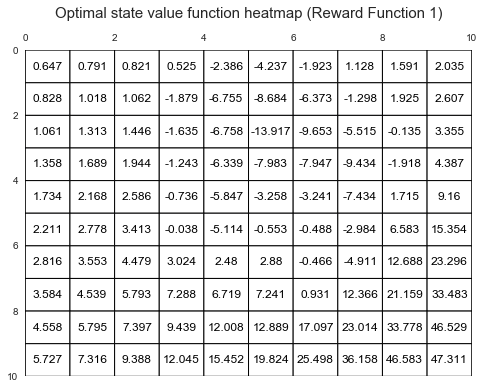

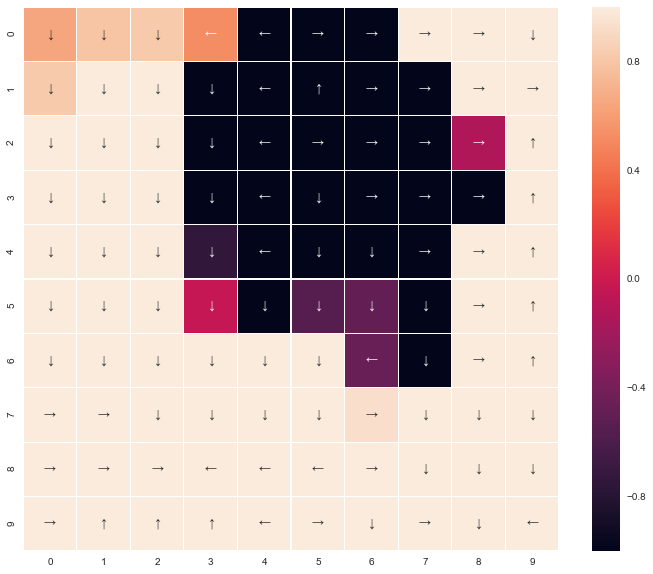

In [386]:
df = pd.DataFrame(optimal_value_state, columns = [i for i in range (cols)], index = [j for j in range(rows)])

#Plotting the optiaml value function
cmap = plt.cm.get_cmap(name = 'gray', lut = 1)
plt.figure(figsize = (8,6))
plt.pcolor(reward_function_2, cmap = cmap, edgecolor = 'k', linewidth = 1)
ax = plt.gca()

for i in range(10):
    for j in range(10):
        text = ax.text(j+0.5, i + 0.5, np.around(optimal_value_state[i][j], decimals = 3),
                  ha = 'center',va = 'center', size = 12, color="k")
plt.title('Optimal state value function plot (Reward Function 1)', y = 1.08, size = 15)
ax.xaxis.tick_top()
ax.invert_yaxis()
ax.xaxis.set_label_position('top')


# #ASK HEATMAP
# #GENERATE HEATMAP
# plt.figure(figsize=(9,7))
# plt.pcolor(optimal_value_state, cmap = 'hot', linewidth = 1, edgecolor = 'b')
# ax = plt.gca()
# ax.invert_yaxis()
# plt.colorbar()
plt.title('Optimal state value function heatmap (Reward Function 1)', y = 1.08, size = 15)
# ax.xaxis.tick_top()
# ax.xaxis.set_label_position('top')
plt.figure(figsize = (12, 10))
sns.heatmap(optimal_value_state, annot=optimal_value_action, linewidths=0.1, fmt='', vmin=-1, vmax=1)

# Do 4
# 5 result here

In [317]:
optimal_value_action = np.asarray(pi_state)

#Convert char to arrow
for i in range(len(optimal_value_action)):
    action = optimal_value_action[i]
    if action == 'U':
        optimal_value_action[i] = '↑'
    elif action == 'D':
        optimal_value_action[i] = '↓'
    elif action == 'R':
        optimal_value_action[i] = '→'
    elif action == 'L':
        optimal_value_action[i] = '←'
        
optimal_value_action = np.reshape(optimal_value_action, (rows,cols), order = 'F')

df = pd.DataFrame(optimal_value_action, columns = [i for i in range (cols)], index = [j for j in range(rows)])
df

#NEED TO PLOT OPTIMAL VALUE PROPERLY
#ASK HEATMAP
#GENERATE HEATMAP

,0,1,2,3,4,5,6,7,8,9
0,→,→,→,→,→,→,→,→,↓,↓
1,↓,→,→,→,→,→,↓,↓,↓,↓
2,↓,↓,→,→,→,↓,↓,↓,↓,↓
3,↓,↓,↓,→,↓,↓,↓,↓,↓,↓
4,↓,↓,↓,→,→,↓,↓,↓,↓,↓
5,↓,↓,→,→,→,↓,↓,↓,↓,↓
6,↓,→,→,→,→,→,→,↓,↓,↓
7,↓,→,→,→,→,→,→,↓,↓,↓
8,→,→,→,→,→,→,→,→,→,↓
9,→,→,→,→,→,→,→,→,→,→


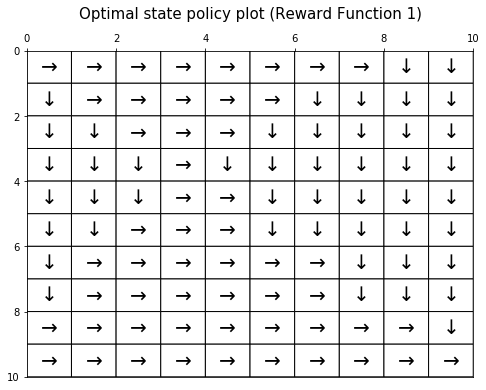

In [318]:
#Plotting the optiaml value function
cmap = plt.cm.get_cmap(name = 'gray', lut = 1)
plt.figure(figsize = (8,6))
plt.pcolor(reward_function_2, cmap = cmap, edgecolor = 'k', linewidth = 1)
ax = plt.gca()

for i in range(10):
    for j in range(10):
        text = ax.text(j+0.5, i + 0.5, optimal_value_action[i][j],
                  ha = 'center',va = 'center', size = 20, color="k")
plt.title('Optimal state policy plot (Reward Function 1)', y = 1.08, size = 15)
ax.xaxis.tick_top()
ax.invert_yaxis()
ax.xaxis.set_label_position('top')

In [319]:
#Reward function (in this case a vector as it depends only on end state) for this computation
reward_function = reward_function_2.flatten('F')
estimation_epsilon = 0.01
[value_state,pi_state] = value_iteration_algo(num_states, action_set, transition_probabilities, 
                                              reward_function, estimation_epsilon, discount_factor)

# Result for q6,7

In [320]:
optimal_value_state = np.asarray(value_state)
optimal_value_state = np.reshape(optimal_value_state, (rows,cols), order = 'F')

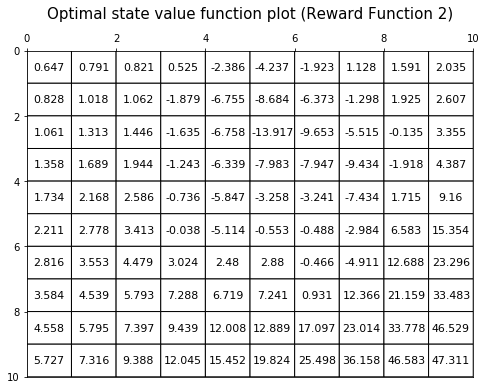

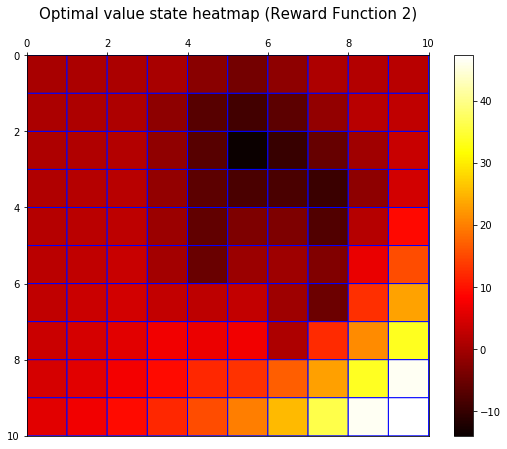

In [321]:
df = pd.DataFrame(optimal_value_state, columns = [i for i in range (cols)], index = [j for j in range(rows)])

#Plotting the optiaml value function
cmap = plt.cm.get_cmap(name = 'gray', lut = 1)
plt.figure(figsize = (8,6))
plt.pcolor(reward_function_2, cmap = cmap, edgecolor = 'k', linewidth = 1)
ax = plt.gca()

for i in range(10):
    for j in range(10):
        text = ax.text(j+0.5, i + 0.5, np.around(optimal_value_state[i][j], decimals = 3),
                  ha = 'center',va = 'center', size = 11, color="k")
plt.title('Optimal state value function plot (Reward Function 2)', y = 1.08, size = 15)
ax.xaxis.tick_top()
ax.invert_yaxis()
ax.xaxis.set_label_position('top')

#NEED TO PLOT OPTIMAL VALUE PROPERLY
#ASK HEATMAP
#GENERATE HEATMAP
plt.figure(figsize=(9,7))
plt.pcolor(optimal_value_state, cmap = 'hot', linewidth = 1, edgecolor = 'b')
ax = plt.gca()
ax.invert_yaxis()
plt.colorbar()
plt.title('Optimal value state heatmap (Reward Function 2)', y = 1.08, size = 15)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')


In [322]:
optimal_value_action = np.asarray(pi_state)

#Convert char to arrow
for i in range(len(optimal_value_action)):
    action = optimal_value_action[i]
    if action == 'U':
        optimal_value_action[i] = '↑'
    elif action == 'D':
        optimal_value_action[i] = '↓'
    elif action == 'R':
        optimal_value_action[i] = '→'
    elif action == 'L':
        optimal_value_action[i] = '←'
        
optimal_value_action = np.reshape(optimal_value_action, (rows,cols), order = 'F')

df = pd.DataFrame(optimal_value_action, columns = [i for i in range (cols)], index = [j for j in range(rows)])
df

#NEED TO PLOT OPTIMAL VALUE PROPERLY
#ASK HEATMAP
#GENERATE HEATMAP


,0,1,2,3,4,5,6,7,8,9
0,↓,↓,↓,←,←,→,→,→,→,↓
1,↓,↓,↓,←,←,↑,→,→,→,↓
2,↓,↓,↓,←,←,↓,→,→,→,↓
3,↓,↓,↓,←,←,↓,↓,↑,→,↓
4,↓,↓,↓,←,←,↓,↓,↓,→,↓
5,↓,↓,↓,←,←,↓,↓,←,→,↓
6,↓,↓,↓,↓,↓,↓,←,←,→,↓
7,↓,↓,↓,↓,↓,↓,←,↓,↓,↓
8,→,→,→,↓,↓,↓,↓,↓,↓,↓
9,→,→,→,→,→,→,→,→,→,→


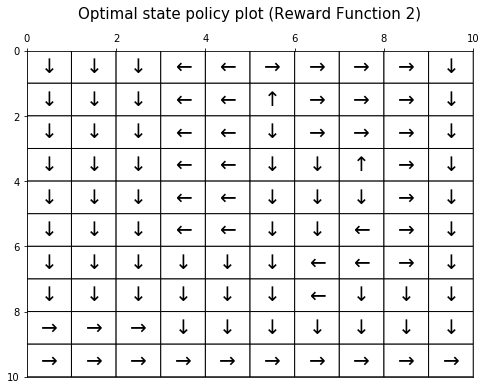

In [323]:
#Plotting the optimal value function
cmap = plt.cm.get_cmap(name = 'gray', lut = 1)
plt.figure(figsize = (8,6))
plt.pcolor(reward_function_2, cmap = cmap, edgecolor = 'k', linewidth = 1)
ax = plt.gca()

for i in range(10):
    for j in range(10):
        text = ax.text(j+0.5, i + 0.5, optimal_value_action[i][j],
                  ha = 'center',va = 'center', size = 20, color="k")
plt.title('Optimal state policy plot (Reward Function 2)', y = 1.08, size = 15)
ax.xaxis.tick_top()
ax.invert_yaxis()
ax.xaxis.set_label_position('top')

In [324]:
# ###################################################
# ##                                               ##
# ##           IRL FUNCTION                        ##
# ##                                               ##
# ###################################################


# def lp_irl(n_s, n_a, transition_probabilities, gamma, lambd, Rmax, policy):
    
#     c = -np.hstack([np.zeros(n_s), np.ones(n_s), -lambd*np.ones(n_s)]).reshape(3*n_s, 1)
#     c = matrix(c)
#     b = np.zeros([2*n_s*(n_a+1)])
    
#     b[2*n_s*(n_a-1): ] = Rmax
    
#     Z = np.zeros([2*(n_a+1)*n_s, 3*n_s])
    
#     for i in range(n_s):
#         a1 = policy[i]
#         inv = np.linalg.inv(np.identity(n_s) - gamma * np.array(transition_probabilities[a1]))
        
#         count = 0
#         for j in action_set:
#             if j != a1:
#                 Z[i * (n_a - 1) + count, :n_s] = -np.dot(np.array(transition_probabilities[a1][i]) - np.array(transition_probabilities[j][i]), inv)
#                 Z[n_s * (n_a - 1) + i * (n_a - 1) + count, :n_s]= -np.dot(np.array(transition_probabilities[a1][i]) - np.array(transition_probabilities[j][i]), inv)
#                 Z[n_s * (n_a - 1) + i * (n_a - 1) + count, n_s + i] = 1
#                 count += 1
                
                
#     for i in range(n_s):
#         Z[2 * n_s * (n_a - 1) + i, i] = -1
#         Z[2 * n_s * (n_a - 1) + n_s + i, i] = 1
#         Z[2 * n_s * (n_a - 1) + 2*n_s + i, i] = 1
#         Z[2 * n_s * (n_a - 1) + 3*n_s + i, i] = -1
        
#         Z[2 * n_s * (n_a - 1) + i, 2*n_s + i] = -1
#         Z[2 * n_s * (n_a - 1) + n_s + i, 2*n_s + i] = -1
        
#     A = matrix(Z)
#     b = matrix(b)
#     solvers.options['show_progress']=False


#     sol = solvers.lp(c, A, b)
#     return (sol['x'][:100])

In [325]:
def lp_irl(n_s, n_a, transition_probabilities, gamma, lambd, Rmax, policy):
    
    c = -np.hstack([np.zeros(n_s), np.ones(n_s), -lambd*np.ones(n_s)]).reshape(3*n_s, 1)
    c = matrix(c)
#     b = np.zeros([2*n_s*(n_a+1)])
    
#     b[2*n_s*(n_a-1): ] = Rmax
    
    Z = np.zeros([2*(n_a+1)*n_s, 3*n_s])
    b = np.zeros([2 * n_s * (n_a + 1)])
#     c = np.zeros([3 * n_s])

    
    for i in range(n_s):
        a1 = policy[i]
        inv = np.linalg.inv(np.identity(n_s) - gamma * np.array(transition_probabilities[a1]))
        
        count = 0
        for j in action_set:
            if j != a1:
                Z[i * (n_a - 1) + count, :n_s] = -np.dot(np.array(transition_probabilities[a1][i]) - np.array(transition_probabilities[j][i]), inv)
                Z[n_s * (n_a - 1) + i * (n_a - 1) + count, :n_s]= -np.dot(np.array(transition_probabilities[a1][i]) - np.array(transition_probabilities[j][i]), inv)
                Z[n_s * (n_a - 1) + i * (n_a - 1) + count, n_s + i] = 1
                count += 1
    
    for i in range(n_s):
        Z[2 * n_s * (n_a - 1) + i, i] = -1
        Z[2 * n_s * (n_a - 1) + i, 2*n_s + i] = -1
        
    for i in range(n_s):
        Z[2 * n_s * (n_a - 1) + n_s + i, i] = 1
        Z[2 * n_s * (n_a - 1) + n_s + i, 2*n_s + i] = -1
        
    for i in range(n_s):
        Z[2 * n_s * (n_a - 1) + 2*n_s + i, i] = 1
        b[2 * n_s * (n_a - 1) + 2*n_s + i] = Rmax
        
    for i in range(n_s):
        Z[2 * n_s * (n_a - 1) + 3*n_s + i, i] = -1
        b[2 * n_s * (n_a - 1) + 3*n_s + i] = Rmax
        
#     c = np.hstack([np.zeros(n_s), -np.ones(n_s), lambd*np.ones(n_s)]).reshape(3*n_s, 1)
#     print(c)
    
# # #     print(type(c))
#     c = matrix(c)
    
#     for i in range(n_s):
#         Z[2 * n_s * (n_a - 1) + i, i] = -1
#         Z[2 * n_s * (n_a - 1) + n_s + i, i] = 1
#         Z[2 * n_s * (n_a - 1) + 2*n_s + i, i] = 1
#         Z[2 * n_s * (n_a - 1) + 3*n_s + i, i] = -1
        
#         Z[2 * n_s * (n_a - 1) + i, 2*n_s + i] = -1
#         Z[2 * n_s * (n_a - 1) + n_s + i, 2*n_s + i] = -1
        
    A = matrix(Z)
    b = matrix(b)
    solvers.options['show_progress']=False


    sol = solvers.lp(c, A, b)
    return (sol['x'][:100])

In [326]:
# def lp_irl(num_states, num_actions, prob_matrix, discount_factor, reg, Rmax, opt_policy):
#     c = np.zeros(3 * num_states)
#     c[num_states:2 * num_states] = -1
#     c[2 * num_states:3 * num_states ] = reg
    
#     h = np.zeros(2 * num_states * (num_actions - 1) + 4 * num_states)
#     h[2 * num_states * (num_actions - 1) + 2 * num_states:2 * num_states * (num_actions - 1) + 4 * num_states ]=Rmax
    
#     G = np.zeros([2 * num_states * (num_actions - 1) + 4 * num_states, 3 * num_states])
    
#     for i in range(num_states):
#         G[2 * num_states * (num_actions - 1) + 2 * num_states+i,i ]=1 #800-900
#         G[2 * num_states * (num_actions - 1) + 3 * num_states+i,i ]=-1 #900-1000
#         G[2 * num_states * (num_actions - 1) + i , i ]=1 #600-700, 1st col
#         G[2 * num_states * (num_actions - 1) + i , 2 * num_states+i ]=-1 #600-700, 3rd col
#         G[2 * num_states * (num_actions - 1) + num_states+i,i ]=-1 #700-800, 1st col
#         G[2 * num_states * (num_actions - 1) +num_states+ i,2 * num_states+i ]=-1 #700-800, 3rd col
    
#     for i in range(num_states):         ##first column for first 600 rows
#         a_i = opt_policy[i]
#         second_term = np.linalg.inv(np.identity(num_states) - discount_factor * np.array(prob_matrix[a_i]))

#         count = 0
#         for a in action_set:
#             if (a != a_i):
#                 G[i * (num_actions - 1) + count, :num_states] = -np.dot(np.array(prob_matrix[a_i][i]) - np.array(prob_matrix[a][i]), second_term)
            
#                 G[num_states * (num_actions - 1) + i * (num_actions - 1) + count, :num_states] = \
#                 -np.dot(np.array(prob_matrix[a_i][i]) - np.array(prob_matrix[a][i]), second_term)
                
#                 G[i * (num_actions - 1) + count, num_states + i] = 1
#                 count += 1
            
#     sol = solvers.lp(matrix(c), matrix(G), matrix(h))
#     return sol['x'][:100]

In [327]:
r = lp_irl(100, 4, transition_probabilities, 0.8, 0.5, 1, pi_state)

r = np.array(r)

r = r.reshape(10, 10)

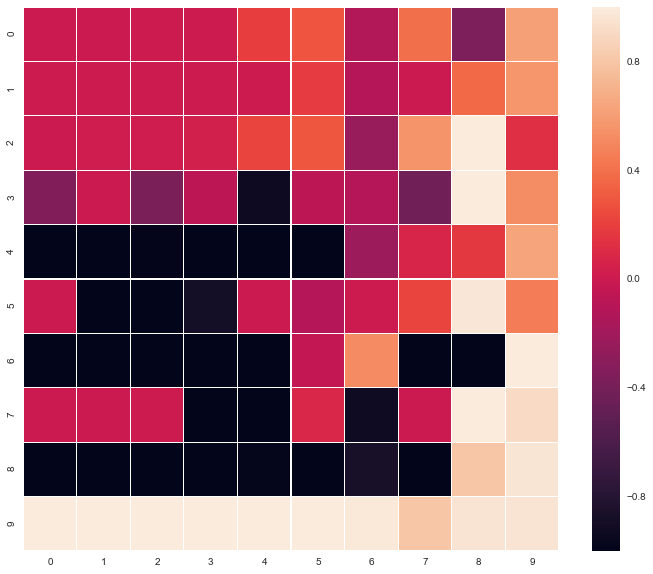

In [390]:
# plt.figure(figsize = (20,20))

# plt.imshow(r, cmap = 'jet')
# ax = plt.gca()
# plt.colorbar()
# #plt.title('Reward Function 1 heatmap', y=1.1)
# for y in range(10):
#     for x in range(10):
#         plt.text(x, y , '%.4f' % int(r[y, x]),
#                  horizontalalignment='center',
#                  verticalalignment='center', fontsize=15, color = 'w'
#                  )
# ax.xaxis.tick_top()
# ax.set_xticks(np.arange(-0.5, 9, 1))
# ax.set_yticks(np.arange(-0.5, 9, 1))
# ax.set_xticklabels(np.arange(0, 10, 1))
# ax.set_yticklabels(np.arange(0, 10, 1))
# ax.grid(color='w', linestyle='-', linewidth=1)

# # plt.text(0.5, 1.08, 'Heatmap for Reward Function 1',
#          horizontalalignment='center',
#          fontsize=40,
#          transform = ax.transAxes)
plt.figure(figsize = (12, 10))
sns.heatmap(r, annot=False, linewidths=0.1, fmt='', vmin=-1, vmax=1)

In [329]:
###################################################
##                                               ##
##    FUNCTION TO CALCULATE ACCURACY             ##
##                                               ##
###################################################

def comp(expert,agent):
  cnt=0
  for i in range(0,100):
    if (expert[i]==agent[i]):
      cnt=cnt+1
      
  accuracy= float(cnt)/100
  
  return accuracy

Expert policy: 
['R', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'R', 'R', 'R', 'R', 'D', 'D', 'D', 'D', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D', 'D', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D', 'D', 'D', 'D', 'R', 'R', 'R', 'R', 'R', 'D', 'D', 'D', 'D', 'D', 'R', 'R', 'R', 'R', 'R', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'R', 'R', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'R', 'R', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'R']
Agent policy: 
[0.63, 0.63, 0.63, 0.65, 0.66, 0.66, 0.66, 0.66, 0.66, 0.65, 0.64, 0.64, 0.64, 0.64, 0.64, 0.65, 0.67, 0.67, 0.66, 0.66, 0.64, 0.64, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.62, 0.62, 0.62, 0.62, 0.64, 0.63, 0.63, 0.63, 0.63, 0.65, 0.65, 0.65, 0.65, 0.65, 0.67, 0.67, 0.66, 0.69, 0.69, 0.66, 0.63, 0.61, 0.6, 0.6, 0.57, 0.57, 0.56, 0.56, 0.57, 0.6, 0.6, 0.53, 0.5, 0.5, 0.49, 0.43, 0.43, 0.43, 0.41, 0.54, 0.64, 0.64, 0.64, 0.64, 0.68, 0.71, 0.71, 0.71,

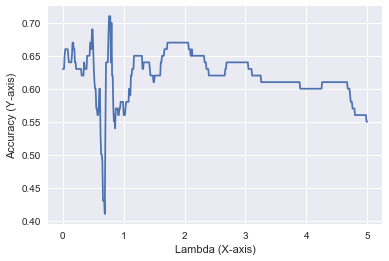

In [391]:
###################################################
##                                               ##
##                   Q11                         ##
##                                               ##
###################################################

#Calculate expert values
[expert_value_state,expert_pi_state] = value_iteration_algo(num_states, action_set, transition_probabilities, 
                                              reward_function_1.flatten('F'), estimation_epsilon, discount_factor)

print('Expert policy: ')
print(expert_pi_state)

#Compare expert values to 500 agent values
acc=[]

for i in range(0, 501):
    lam=i/100
    irl_new=lp_irl(100, 4, transition_probabilities, 0.8, lam, 1, expert_pi_state)
    [agent_value_state,agent_pi_state] = value_iteration_algo(num_states, action_set, transition_probabilities, 
                                                irl_new, estimation_epsilon, discount_factor)
    acc.append(comp(expert_pi_state,agent_pi_state))
#     print(comp(expert_pi_state,agent_pi_state))
  
    
lam_list=[]
for i in range(0, 501):
    lam=i/100
    lam_list.append(lam)

print('Agent policy: ')
print(acc)

#Plot acccuracy
plt.plot(lam_list,acc)
plt.xlabel('Lambda (X-axis)')
plt.ylabel('Accuracy (Y-axis)')
plt.show()

In [392]:
###################################################
##                                               ##
##                   Q12                         ##
##                                               ##
###################################################

#value 1 is equivalent to 0.1
print(np.argmax(acc))
print(acc[np.argmax(acc)])

lambda_max = max(acc)
print(lambda_max)

76
0.71
0.71


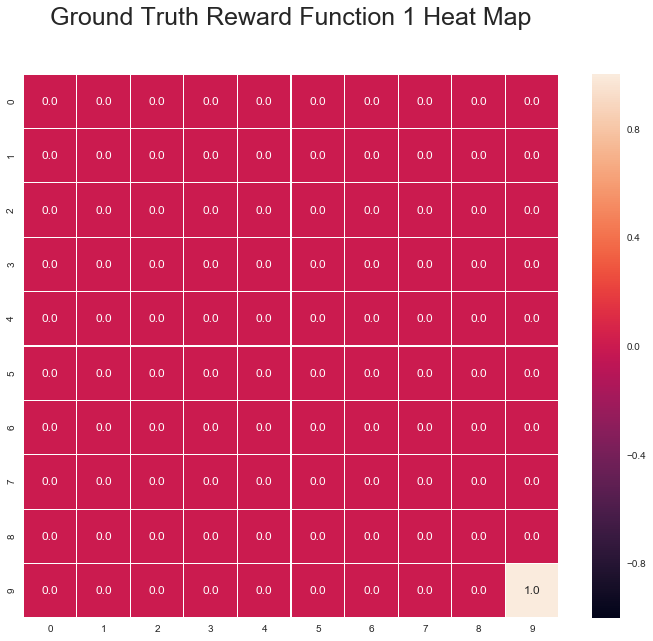

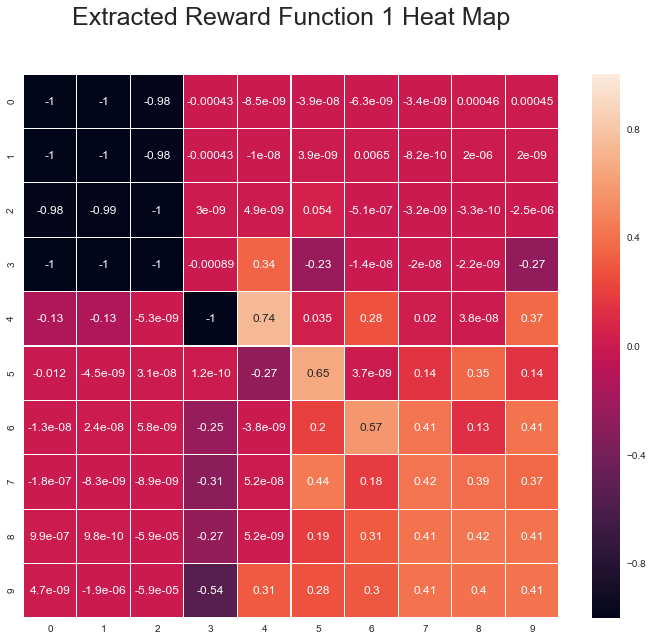

In [424]:
###################################################
##                                               ##
##                   Q13                         ##
##                                               ##
###################################################

#Ground Truth Reward Heat Map
# plt.figure(figsize=(9,7))
# plt.pcolor(reward_function_1, linewidth = 1.5, edgecolor = 'w',cmap = 'jet')
# ax = plt.gca()
# ax.invert_yaxis()
# plt.colorbar()
# fig, ax = plt.subplots(1, 2, figsize=(25, 10))
# ax.xaxis.tick_top()
# ax.xaxis.set_label_position('top')
plt.figure(figsize = (12, 10))
plt.title('Ground Truth Reward Function 1 Heat Map', y = 1.08, size = 25)
sns.heatmap(reward_function_1, annot=reward_function_1, linewidths=0.1, fmt='', vmin=-1, vmax=1)
plt.show()

#Extracted Reward Heat Map
a=[]

temp_irl=lp_irl(100, 4, transition_probabilities, 0.8, lambda_max, 1, expert_pi_state)

a=temp_irl
a = np.array(a)
a = a.reshape(10, 10, order='F')

# plt.figure(figsize=(9,7))
# plt.pcolor(a, linewidth = 1.5, edgecolor = 'w',cmap = 'jet')
# ax = plt.gca()
# ax.invert_yaxis()
# plt.colorbar()
# ax.xaxis.tick_top()
# ax.xaxis.set_label_position('top')
plt.figure(figsize = (12, 10))
plt.title('Extracted Reward Function 1 Heat Map', y = 1.08, size = 25)
sns.heatmap(a, annot=True, linewidths=0.1, vmin=-1, vmax=1)
plt.show()

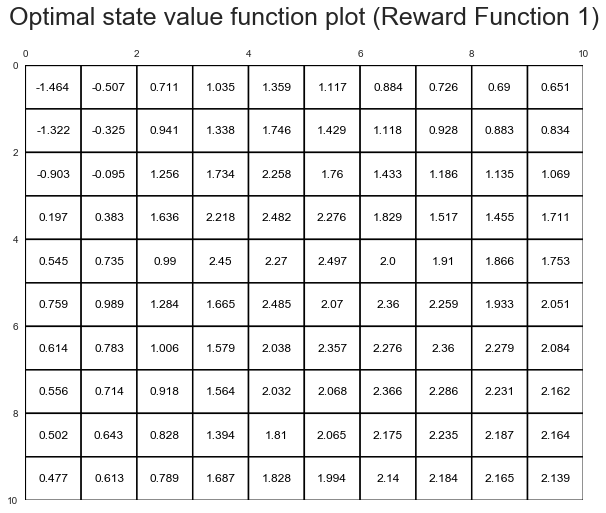

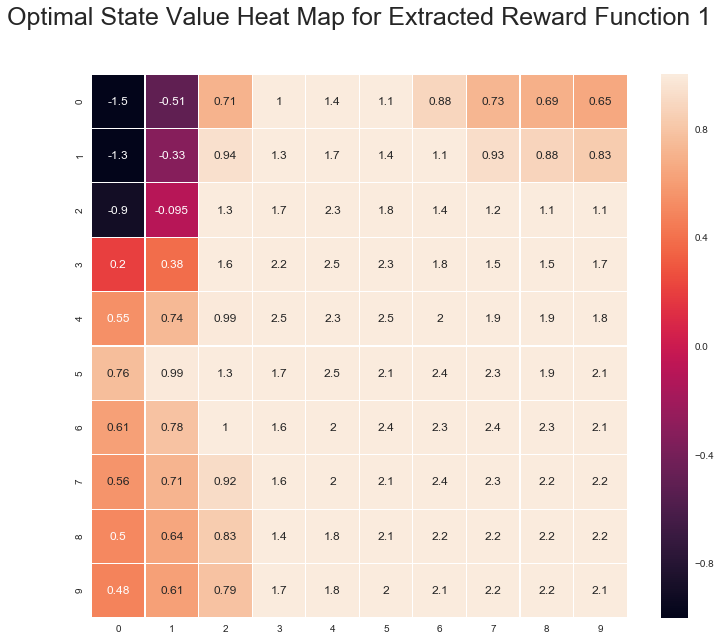

In [433]:
###################################################
##                                               ##
##                   Q14                         ##
##                                               ##
###################################################

temp_irl=lp_irl(100, 4, transition_probabilities, 0.8, lambda_max, 1, expert_pi_state)

[temp_agent_value_state,temp_agent_pi_state] = value_iteration_algo(num_states, action_set, transition_probabilities, 
                                              temp_irl, estimation_epsilon, discount_factor)

temp_optimal_value_state = np.asarray(temp_agent_value_state)
temp_optimal_value_state = np.reshape(temp_optimal_value_state, (rows,cols), order = 'F')


#Optimal Value plotting in 2D grid
#print(temp_optimal_value_state)
cmap = plt.cm.get_cmap(name = 'gray', lut = 1)
plt.figure(figsize = (10,8))
plt.pcolor(reward_function_1, cmap = cmap, edgecolor = 'k', linewidth = 1.5)
ax = plt.gca()

for i in range(10):
    for j in range(10):
        text = ax.text(j+0.5, i + 0.5, np.around(temp_optimal_value_state[i][j], decimals = 3),
                  ha = 'center',va = 'center', size = 12, color="k")
plt.title('Optimal state value function plot (Reward Function 1)', y = 1.08, size = 25)
ax.xaxis.tick_top()
ax.invert_yaxis()
ax.xaxis.set_label_position('top')



#Heat Map
# plt.figure(figsize=(9,7))
# plt.pcolor(temp_optimal_value_state, linewidth = 1.5, edgecolor = 'w',cmap = 'jet')
# ax = plt.gca()
# ax.invert_yaxis()
# plt.colorbar()
# plt.title('Optimal State Value Heat Map for Extracted Reward Function 1', y = 1.08, size = 15)
# ax.xaxis.tick_top()
# ax.xaxis.set_label_position('top')

plt.figure(figsize = (12, 10))
plt.title('Optimal State Value Heat Map for Extracted Reward Function 1', y = 1.08, size = 25)
sns.heatmap(temp_optimal_value_state, annot=True, linewidths=0.1, vmin=-1, vmax=1)
plt.show()

In [436]:
###################################################
##                                               ##
##                   Q16                         ##
##                                               ##
###################################################

temp_irl=lp_irl(100, 4, transition_probabilities, 0.8, lambda_max, 1, expert_pi_state)

[temp_agent_value_state,temp_agent_pi_state] = value_iteration_algo(num_states, action_set, transition_probabilities, 
                                              temp_irl, estimation_epsilon, discount_factor)

optimal_value_action = np.asarray(temp_agent_pi_state)

#Convert char to arrow
for i in range(len(optimal_value_action)):
    action = optimal_value_action[i]
    if action == 'U':
        optimal_value_action[i] = '↑'
    elif action == 'D':
        optimal_value_action[i] = '↓'
    elif action == 'R':
        optimal_value_action[i] = '→'
    elif action == 'L':
        optimal_value_action[i] = '←'
        
optimal_value_action = np.reshape(optimal_value_action, (rows,cols), order = 'F')

df = pd.DataFrame(optimal_value_action, columns = [i for i in range (cols)], index = [j for j in range(rows)])
df

# plt.figure(figsize = (12, 10))
# # plt.title('Optimal State Value Heat Map for Extracted Reward Function 1', y = 1.08, size = 25)
# sns.heatmap(temp_optimal_value_state, annot=optimal_value_action, fmt='',  linewidths=0.1, vmin=-1, vmax=1)
# plt.show()

,0,1,2,3,4,5,6,7,8,9
0,→,→,→,→,↓,↓,↓,↓,↓,↓
1,→,→,→,→,↓,↓,↓,↓,↓,↓
2,↓,→,→,→,↓,←,↓,↓,↓,↓
3,↓,↓,→,→,↓,←,↓,↓,↓,↓
4,↓,→,↓,→,↑,←,←,↓,↓,↓
5,→,→,→,→,↑,↓,↓,↓,↓,↓
6,→,→,↑,→,→,→,→,←,←,↓
7,→,→,→,→,→,↑,↑,↑,←,←
8,→,→,→,→,→,↑,→,↑,←,←
9,→,→,→,→,→,→,→,↑,↑,↑


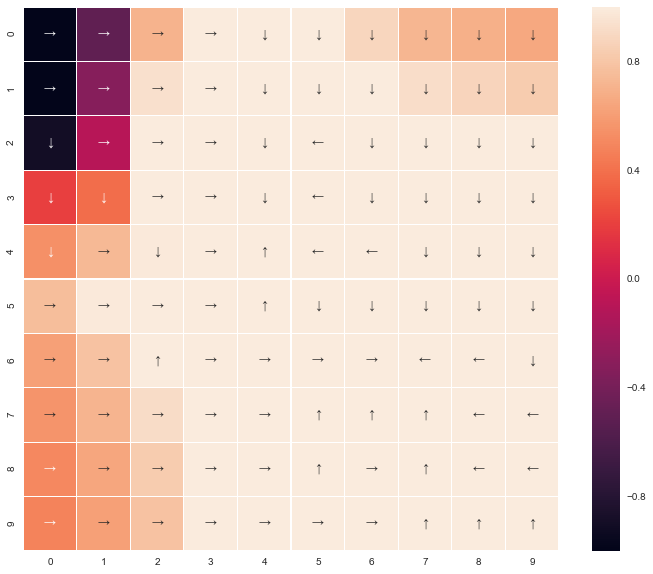

In [438]:
plt.figure(figsize = (12, 10))
# plt.title('Optimal State Value Heat Map for Extracted Reward Function 1', y = 1.08, size = 25)
sns.heatmap(temp_optimal_value_state, annot=optimal_value_action, fmt='',  linewidths=0.1, vmin=-1, vmax=1)
plt.show()

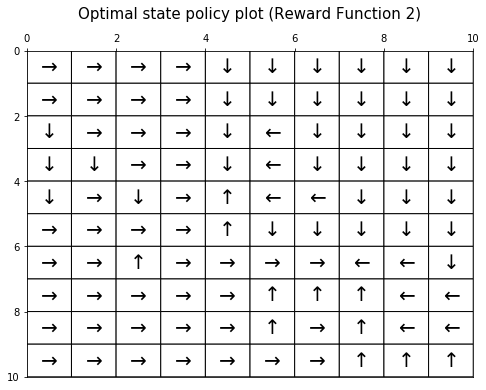

In [344]:
cmap = plt.cm.get_cmap(name = 'gray', lut = 1)
plt.figure(figsize = (8,6))
plt.pcolor(reward_function_2, cmap = cmap, edgecolor = 'k', linewidth = 1)
ax = plt.gca()

for i in range(10):
    for j in range(10):
        text = ax.text(j+0.5, i + 0.5, optimal_value_action[i][j],
                  ha = 'center',va = 'center', size = 20, color="k")
plt.title('Optimal state policy plot (Reward Function 2)', y = 1.08, size = 15)
ax.xaxis.tick_top()
ax.invert_yaxis()
ax.xaxis.set_label_position('top')

0.0 0.72
0.01 0.72
0.02 0.72
0.03 0.72
0.04 0.74
0.05 0.66
0.06 0.65
0.07 0.65
0.08 0.66
0.09 0.67
0.1 0.67
0.11 0.67
0.12 0.67
0.13 0.67
0.14 0.67
0.15 0.69
0.16 0.72
0.17 0.71
0.18 0.71
0.19 0.71
0.2 0.72
0.21 0.72
0.22 0.71
0.23 0.69
0.24 0.71
0.25 0.72
0.26 0.72
0.27 0.72
0.28 0.72
0.29 0.68
0.3 0.68
0.31 0.68
0.32 0.68
0.33 0.68
0.34 0.68
0.35 0.68
0.36 0.68
0.37 0.68
0.38 0.69
0.39 0.69
0.4 0.69
0.41 0.69
0.42 0.69
0.43 0.69
0.44 0.69
0.45 0.68
0.46 0.66
0.47 0.66
0.48 0.68
0.49 0.68
0.5 0.7
0.51 0.71
0.52 0.71
0.53 0.71
0.54 0.7
0.55 0.72
0.56 0.73
0.57 0.72
0.58 0.72
0.59 0.71
0.6 0.71
0.61 0.71
0.62 0.71
0.63 0.7
0.64 0.7
0.65 0.7
0.66 0.7
0.67 0.7
0.68 0.7
0.69 0.7
0.7 0.69
0.71 0.69
0.72 0.7
0.73 0.67
0.74 0.68
0.75 0.68
0.76 0.69
0.77 0.69
0.78 0.69
0.79 0.68
0.8 0.68
0.81 0.68
0.82 0.68
0.83 0.69
0.84 0.68
0.85 0.68
0.86 0.66
0.87 0.66
0.88 0.66
0.89 0.68
0.9 0.69
0.91 0.69
0.92 0.68
0.93 0.68
0.94 0.68
0.95 0.68
0.96 0.7
0.97 0.7
0.98 0.7
0.99 0.69
1.0 0.69
1.01 0.69
1.02

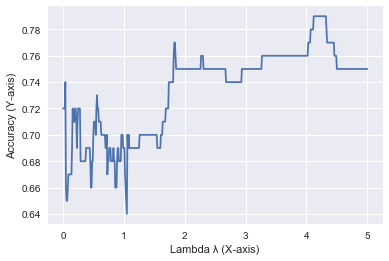

In [439]:
###################################################
##                                               ##
##                   Q17                         ##
##                                               ##
###################################################

#Calculate expert values
[expert_value_state,expert_pi_state] = value_iteration_algo(num_states, action_set, transition_probabilities, 
                                              reward_function_2.flatten('F'), estimation_epsilon, discount_factor)


#Compare expert values to 500 agent values
acc=[]

for i in range(0, 501):
  lam=i/100
  irl_new=lp_irl(100, 4, transition_probabilities, 0.8, lam, 10, expert_pi_state)
  temp_stuff = []
  for tttt in irl_new:
    temp_stuff.append(tttt)
  [agent_value_state,agent_pi_state] = value_iteration_algo(num_states, action_set, transition_probabilities, 
                                              temp_stuff, estimation_epsilon, discount_factor)
  acc.append(comp(expert_pi_state,agent_pi_state))
  print(lam, comp(expert_pi_state,agent_pi_state))
  
lam_list=[]
for i in range(0, 501):
  lam=i/100
  lam_list.append(lam)
  
#Plot acccuracy
plt.plot(lam_list,acc)
plt.xlabel('Lambda λ (X-axis)')
plt.ylabel('Accuracy (Y-axis)')
plt.show()

In [440]:
###################################################
##                                               ##
##                   Q18                         ##
##                                               ##
###################################################

#value 1 is equivalent to 0.1
print(np.argmax(acc))
print(acc[np.argmax(acc)])
lambda_max_2 = max(acc)
print(lambda_max_2)

412
0.79
0.79


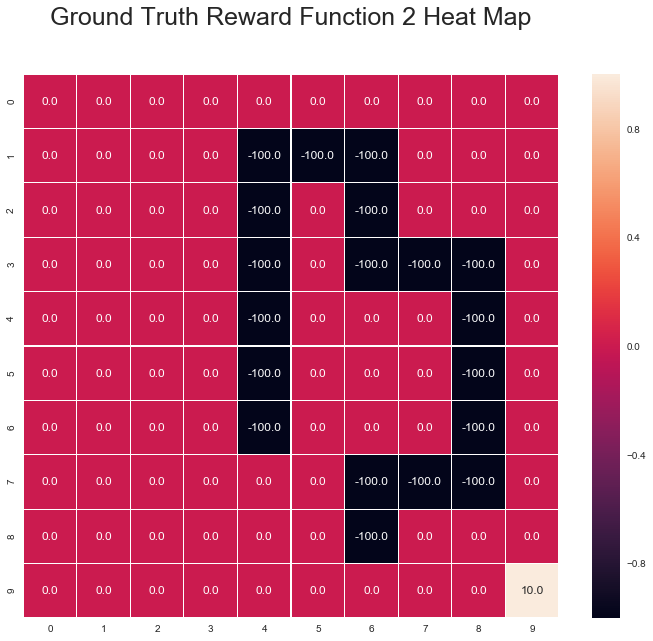

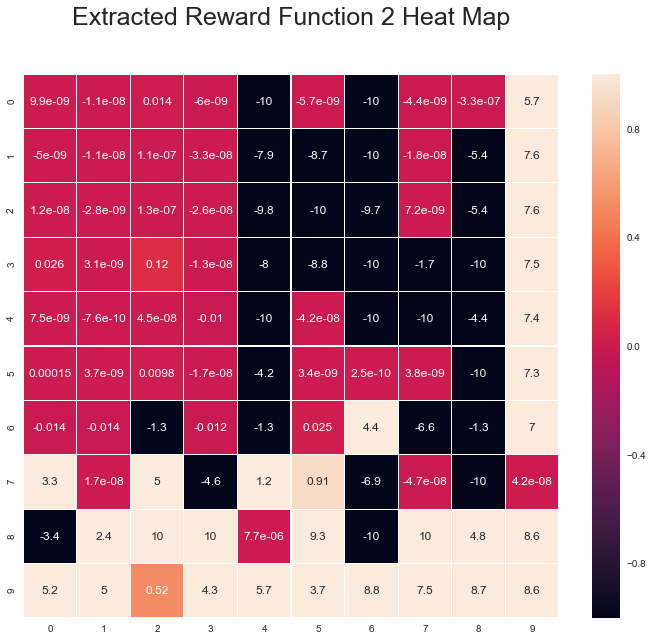

In [466]:
###################################################
##                                               ##
##                   Q19                         ##
##                                               ##
###################################################

#Ground Truth Reward Heat Map
# plt.figure(figsize=(9,7))
# plt.pcolor(reward_function_2, linewidth = 1.5, edgecolor = 'w',cmap = 'jet')
# ax = plt.gca()
# ax.invert_yaxis()
# plt.colorbar()
# plt.title('Ground Truth Reward Function 2 Heat Map', y = 1.08, size = 15)
# ax.xaxis.tick_top()
# ax.xaxis.set_label_position('top')

plt.figure(figsize = (12, 10))
plt.title('Ground Truth Reward Function 2 Heat Map', y = 1.08, size = 25)
sns.heatmap(reward_function_2, annot=reward_function_2, fmt='',  linewidths=0.1, vmin=-1, vmax=1)
plt.show()

#Extracted Reward Heat Map
a=[]

temp_irl=lp_irl(100, 4, transition_probabilities, 0.8, lambda_max_2, 10, expert_pi_state)

a=temp_irl
a = np.array(a)
a = a.reshape(10, 10, order='F')

# plt.figure(figsize=(9,7))
# plt.pcolor(a, linewidth = 1.5, edgecolor = 'w',cmap = 'jet')
# ax = plt.gca()
# ax.invert_yaxis()
# plt.colorbar()
# plt.title('Extracted Reward Function 2 Heat Map', y = 1.08, size = 15)
# ax.xaxis.tick_top()
# ax.xaxis.set_label_position('top')

plt.figure(figsize = (12, 10))
plt.title('Extracted Reward Function 2 Heat Map', y = 1.08, size = 25)
sns.heatmap(a, annot=True,  linewidths=0.1, vmin=-1, vmax=1)
plt.show()

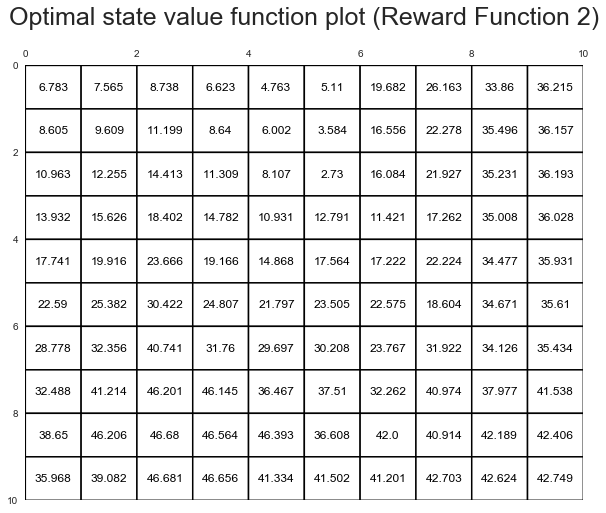

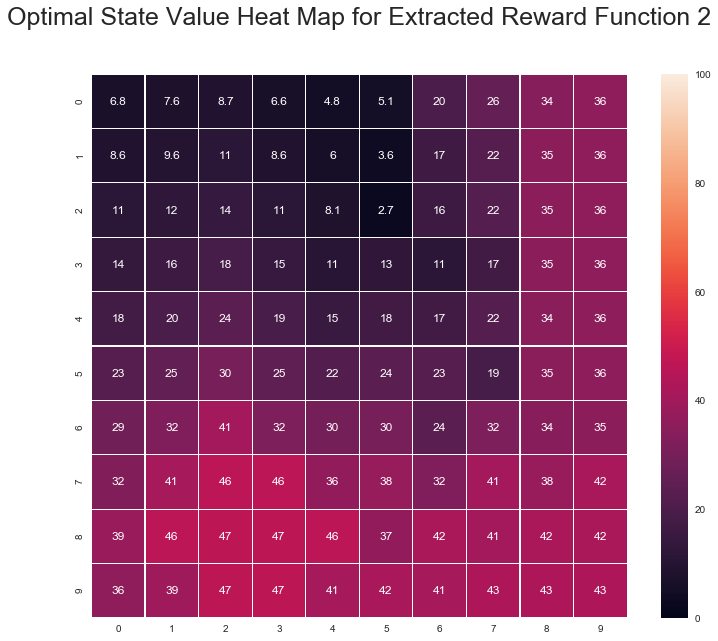

In [461]:
###################################################
##                                               ##
##                   Q20                         ##
##                                               ##
###################################################

temp_irl=lp_irl(100, 4, transition_probabilities, 0.8, lambda_max_2, 10, expert_pi_state)

[temp_agent_value_state,temp_agent_pi_state] = value_iteration_algo(num_states, action_set, transition_probabilities, 
                                              temp_irl, estimation_epsilon, discount_factor)

temp_optimal_value_state = np.asarray(temp_agent_value_state)
temp_optimal_value_state = np.reshape(temp_optimal_value_state, (rows,cols), order = 'F')


#Optimal Value plotting in 2D grid
#print(temp_optimal_value_state)
cmap = plt.cm.get_cmap(name = 'gray', lut = 1)
plt.figure(figsize = (10,8))
plt.pcolor(reward_function_2, cmap = cmap, edgecolor = 'k', linewidth = 1.5)
ax = plt.gca()

for i in range(10):
    for j in range(10):
        text = ax.text(j+0.5, i + 0.5, np.around(temp_optimal_value_state[i][j], decimals = 3),
                  ha = 'center',va = 'center', size = 12, color="k")
plt.title('Optimal state value function plot (Reward Function 2)', y = 1.08, size = 25)
ax.xaxis.tick_top()
ax.invert_yaxis()
ax.xaxis.set_label_position('top')



#Heat Map
# plt.figure(figsize=(9,7))
# plt.pcolor(temp_optimal_value_state, linewidth = 1.5, edgecolor = 'w',cmap = 'jet')
# ax = plt.gca()
# ax.invert_yaxis()
# plt.colorbar()
# plt.title('Optimal State Value Heat Map for Extracted Reward Function 2', y = 1.08, size = 15)
# ax.xaxis.tick_top()
# ax.xaxis.set_label_position('top')

plt.figure(figsize = (12, 10))
plt.title('Optimal State Value Heat Map for Extracted Reward Function 2', y = 1.08, size = 25)
sns.heatmap(temp_optimal_value_state, annot=True,  linewidths=0.1, vmin=0, vmax=100)
plt.show()

In [462]:
###################################################
##                                               ##
##                   Q21                         ##
##                                               ##
###################################################

temp_irl=lp_irl(100, 4, transition_probabilities, 0.8, lambda_max_2, 10, expert_pi_state)

[temp_agent_value_state,temp_agent_pi_state] = value_iteration_algo(num_states, action_set, transition_probabilities, 
                                              temp_irl, estimation_epsilon, discount_factor)

optimal_value_action = np.asarray(temp_agent_pi_state)

#Convert char to arrow
for i in range(len(optimal_value_action)):
    action = optimal_value_action[i]
    if action == 'U':
        optimal_value_action[i] = '↑'
    elif action == 'D':
        optimal_value_action[i] = '↓'
    elif action == 'R':
        optimal_value_action[i] = '→'
    elif action == 'L':
        optimal_value_action[i] = '←'
        
optimal_value_action = np.reshape(optimal_value_action, (rows,cols), order = 'F')

df = pd.DataFrame(optimal_value_action, columns = [i for i in range (cols)], index = [j for j in range(rows)])
df

,0,1,2,3,4,5,6,7,8,9
0,↓,↓,↓,←,←,→,→,→,→,↓
1,↓,↓,↓,↓,←,↑,→,→,→,→
2,↓,↓,↓,↓,←,→,→,→,→,↑
3,↓,↓,↓,↓,←,↓,→,→,→,↑
4,↓,↓,↓,↓,←,↓,↓,→,→,↑
5,↓,↓,↓,↓,↓,↓,↓,↓,→,↑
6,↓,↓,↓,↓,↓,↓,←,↓,→,↑
7,→,→,↓,↓,↓,↓,→,↓,↓,↓
8,→,→,→,←,←,←,→,↓,↓,↓
9,→,↑,↑,↑,←,→,↓,→,↓,←


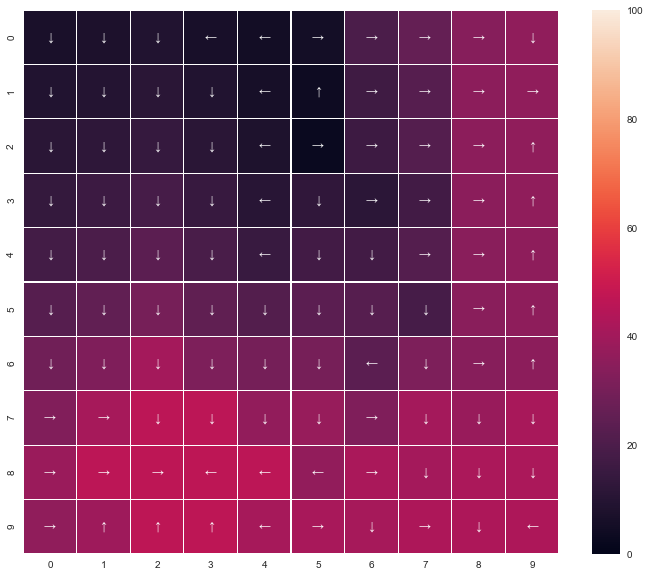

In [464]:
plt.figure(figsize = (12, 10))
# plt.title('Optimal State Value Heat Map for Extracted Reward Function 1', y = 1.08, size = 25)
sns.heatmap(temp_optimal_value_state, annot=optimal_value_action, fmt='',  linewidths=0.1, vmin=0, vmax=100)
plt.show()

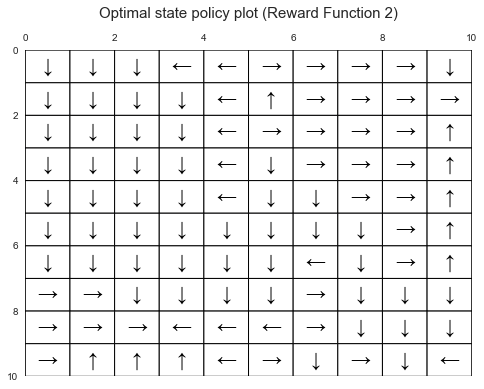

In [469]:
#Plotting the optimal value function
cmap = plt.cm.get_cmap(name = 'gray', lut = 1)
plt.figure(figsize = (8,6))
plt.pcolor(reward_function_2, cmap = cmap, edgecolor = 'k', linewidth = 1)
ax = plt.gca()

for i in range(10):
    for j in range(10):
        text = ax.text(j+0.5, i + 0.5, optimal_value_action[i][j],
                  ha = 'center',va = 'center', size = 20, color="k")
plt.title('Optimal state policy plot (Reward Function 2)', y = 1.08, size = 15)
ax.xaxis.tick_top()
ax.invert_yaxis()
ax.xaxis.set_label_position('top')

In [471]:
temp_irl=lp_irl(100, 4, transition_probabilities, 0.8, lambda_max_2, 10, expert_pi_state)
temp_stuff = []
for v in temp_irl:
  temp_stuff.append(v)
print(temp_stuff)
# print(temp_irl)

[9.942828809338667e-09, -5.013306323532567e-09, 1.2124019362372935e-08, 0.026105567219131112, 7.530181350770015e-09, 0.00014659390833864078, -0.014283806941048159, 3.320038035955927, -3.371397954434155, 5.224177816848203, -1.050060546356301e-08, -1.0715253213831555e-08, -2.8337940843280666e-09, 3.143637328741907e-09, -7.613120229845921e-10, 3.709306186802061e-09, -0.014283789981761304, 1.695836584368453e-08, 2.3707255384773562, 5.044253542374189, 0.01389054534441407, 1.1000902796763007e-07, 1.3091514702132647e-07, 0.11669982715030251, 4.4959510885138984e-08, 0.00984988288968403, -1.293091311010596, 5.047945382142224, 9.999999995857717, 0.5161098144118772, -5.978657578695074e-09, -3.324151483601264e-08, -2.62995832726953e-08, -1.2716016906210288e-08, -0.010061775420359628, -1.666680835050903e-08, -0.012383313810941748, -4.5624805027984, 9.999999995000717, 4.32133340074614, -9.999999980628498, -7.897441022544394, -9.832676066038703, -7.9976860448375895, -9.99999997825569, -4.166600934942

In [353]:
reward_function = reward_function_1.flatten('F')
print(reward_function)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1.]


In [354]:
[expert_value_state,expert_pi_state] = value_iteration_algo(num_states, action_set, transition_probabilities, 
                                              reward_function_2.flatten('F'), estimation_epsilon, discount_factor)

acc=[]

for i in range(0, 501):
  lam=i/100
  irl_new=lp_irl(100, 4, transition_probabilities, 0.8, lam, 1, pi_state)
  [agent_value_state,agent_pi_state] = value_iteration_algo(num_states, action_set, transition_probabilities, 
                                              irl_new, estimation_epsilon, discount_factor)
  acc.append(comp(expert_pi_state,agent_pi_state))
  

KeyboardInterrupt: 

[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0, 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09, 1.1, 1.11, 1.12, 1.13, 1.14, 1.15, 1.16, 1.17, 1.18, 1.19, 1.2, 1.21, 1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3, 1.31, 1.32, 1.33, 1.34, 1.35, 1.36, 1.37, 1.38, 1.39, 1.4, 1.41, 1.42, 1.43, 1.44, 1.45, 1.46, 1.47, 1.48, 1.49, 1.5, 1.51, 1.52, 1.53, 1.54, 1.55, 1.56, 1.57, 1.58, 1.59, 1.6, 1.61, 1.62, 1.63, 1.64, 1.65, 1.66, 1.67, 1.68, 1.

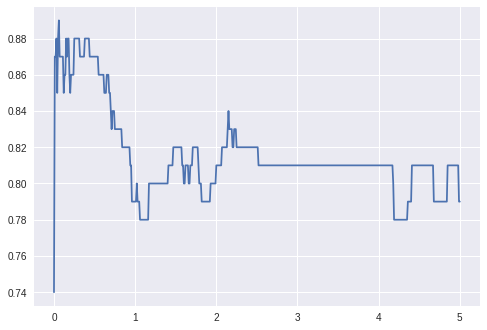

In [37]:
lam_list=[]
for i in range(0, 501):
  lam=i/100
  lam_list.append(lam)
print(lam_list)

plt.plot(lam_list,acc)

In [355]:
print(np.argmax(acc))

4


In [ ]:
a=[]

nn_irl=lp_irl(100, 4, transition_probabilities, 0.8, lamb, 1, expert_pi_state)

a=nn_irl
a = np.array(a)
a = a.reshape(10, 10, order='F')

plt.figure(figsize = (20,20))

plt.imshow(a, cmap = 'jet')
ax = plt.gca()
plt.colorbar()
#plt.title('Reward Function 1 heatmap', y=1.1)
for y in range(10):
    for x in range(10):
        plt.text(x, y , '%.4f' % int(a[y, x]),
                 horizontalalignment='center',
                 verticalalignment='center', fontsize=15, color = 'w'
                 )
ax.xaxis.tick_top()
ax.set_xticks(np.arange(-0.5, 9, 1))
ax.set_yticks(np.arange(-0.5, 9, 1))
ax.set_xticklabels(np.arange(0, 10, 1))
ax.set_yticklabels(np.arange(0, 10, 1))
ax.grid(color='w', linestyle='-', linewidth=1)

plt.text(0.5, 1.08, 'Heatmap for Reward Function 1',
         horizontalalignment='center',
         fontsize=40,
         transform = ax.transAxes)
ax.xaxis.set_label_position('top')

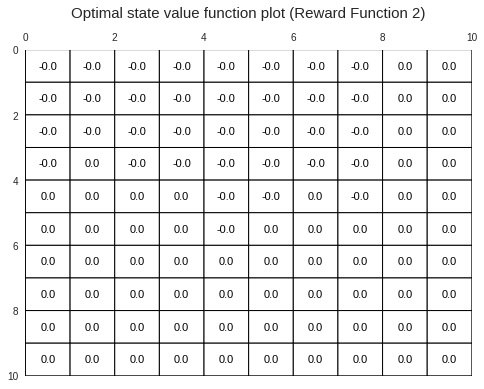

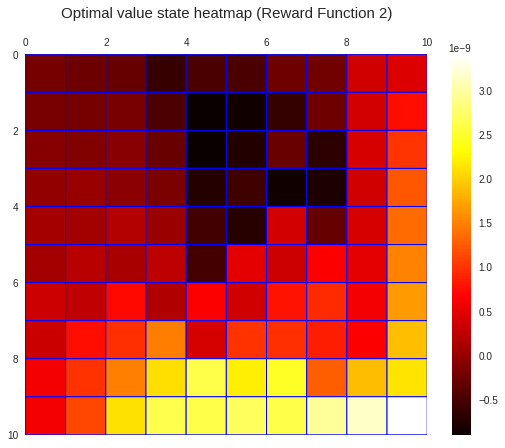

In [40]:
[new_agent_value_state,new_agent_pi_state] = value_iteration_algo(num_states, action_set, transition_probabilities, 
                                              nn_irl, estimation_epsilon, discount_factor)

new_optimal_value_state = np.asarray(new_agent_value_state)
new_optimal_value_state = np.reshape(new_optimal_value_state, (rows,cols), order = 'F')


df = pd.DataFrame(new_optimal_value_state, columns = [i for i in range (cols)], index = [j for j in range(rows)])

#Plotting the optiaml value function
cmap = plt.cm.get_cmap(name = 'gray', lut = 1)
plt.figure(figsize = (8,6))
plt.pcolor(reward_function_2, cmap = cmap, edgecolor = 'k', linewidth = 1)
ax = plt.gca()

for i in range(10):
    for j in range(10):
        text = ax.text(j+0.5, i + 0.5, np.around(new_optimal_value_state[i][j], decimals = 3),
                  ha = 'center',va = 'center', size = 11, color="k")
plt.title('Optimal state value function plot (Reward Function 2)', y = 1.08, size = 15)
ax.xaxis.tick_top()
ax.invert_yaxis()
ax.xaxis.set_label_position('top')

#NEED TO PLOT OPTIMAL VALUE PROPERLY
#ASK HEATMAP
#GENERATE HEATMAP
plt.figure(figsize=(9,7))
plt.pcolor(new_optimal_value_state, cmap = 'hot', linewidth = 1, edgecolor = 'b')
ax = plt.gca()
ax.invert_yaxis()
plt.colorbar()
plt.title('Optimal value state heatmap (Reward Function 2)', y = 1.08, size = 15)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')


In [0]:
[new_agent_value_state,new_agent_pi_state] = value_iteration_algo(num_states, action_set, transition_probabilities, 
                                              nn_irl, estimation_epsilon, discount_factor)

optimal_value_action = np.asarray(new_agent_pi_state)

#Convert char to arrow
for i in range(len(optimal_value_action)):
    action = optimal_value_action[i]
    if action == 'U':
        optimal_value_action[i] = '↑'
    elif action == 'D':
        optimal_value_action[i] = '↓'
    elif action == 'R':
        optimal_value_action[i] = '→'
    elif action == 'L':
        optimal_value_action[i] = '←'
        
optimal_value_action = np.reshape(optimal_value_action, (rows,cols), order = 'F')

df = pd.DataFrame(optimal_value_action, columns = [i for i in range (cols)], index = [j for j in range(rows)])

In [42]:
qwqw=[2,3,0,-1,29,99,1]
np.argmax(qwqw)

5